In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# AFL field dimensions
FIELD_LENGTH = 159.5  # metres
FIELD_WIDTH = 128.8
A = FIELD_LENGTH / 2
B = FIELD_WIDTH / 2


In [ ]:

df = pd.read_csv("tracking_csv.csv")
df.head()


,frame_id,player_id,timestamp_s,x1,y1,x2,y2,cx,cy,w,h,confidence
0,1,1,0.00,624,478,841,964,732,721,217,485,0.77
1,1,2,0.00,534,419,772,872,653,645,238,452,0.74
2,2,1,0.04,613,482,807,964,710,723,193,481,0.86
3,2,2,0.04,486,418,744,855,615,636,257,436,0.84
4,3,1,0.08,621,483,788,968,704,725,166,484,0.80


In [ ]:
import numpy as np

def raw_bbox(xs, ys, pad_ratio=0.02):
    xmin, xmax = np.min(xs), np.max(xs)
    ymin, ymax = np.min(ys), np.max(ys)
    dx, dy = xmax - xmin, ymax - ymin
    return (xmin - dx * pad_ratio, xmax + dx * pad_ratio,
            ymin - dy * pad_ratio, ymax + dy * pad_ratio)

def raw_to_metres(x, y, bbox_raw, a=82.5, b=67.5):
    xmin, xmax, ymin, ymax = bbox_raw
    x_m = ((x - xmin) / max(1e-9, xmax - xmin)) * (2 * a) - a
    y_m = ((y - ymin) / max(1e-9, ymax - ymin)) * (2 * b) - b
    return x_m, y_m

# Drop incomplete rows and convert
df = df.dropna(subset=["cx", "cy", "timestamp_s", "player_id"])
df["timestamp_s"] = pd.to_numeric(df["timestamp_s"], errors="coerce")
df["player_id"] = pd.to_numeric(df["player_id"], errors="coerce")
df = df.sort_values(by=["player_id", "timestamp_s"])

bbox = raw_bbox(df["cx"].values, df["cy"].values)
df["x_m"], df["y_m"] = raw_to_metres(df["cx"], df["cy"], bbox)


In [ ]:
zone_times = []

for pid, group in df.groupby("player_id"):
    group = group.sort_values("timestamp_s")
    timestamps = group["timestamp_s"].values
    x_vals = group["x_m"].values

    if len(timestamps) < 2:
        continue

    dt = np.diff(timestamps)
    zones = []

    for i in range(len(dt)):
        x = x_vals[i]
        if x < -50:
            zones.append("back_50")
        elif x > 50:
            zones.append("forward_50")
        else:
            zones.append("midfield")

    zone_time = {"player_id": pid, "back_50": 0.0, "midfield": 0.0, "forward_50": 0.0}
    for i, z in enumerate(zones):
        zone_time[z] += dt[i]

    zone_times.append(zone_time)


In [ ]:
zone_df = pd.DataFrame(zone_times)
zone_df = zone_df[["player_id", "back_50", "midfield", "forward_50"]]
zone_df.to_csv("zone_time_summary.csv", index=False)
zone_df.head()


,player_id,back_50,midfield,forward_50
0,1,0.00,7.36,0.00
1,2,0.00,7.36,0.00
2,5,0.28,2.24,0.52
3,34,0.00,0.24,0.00
4,36,0.48,0.96,0.00


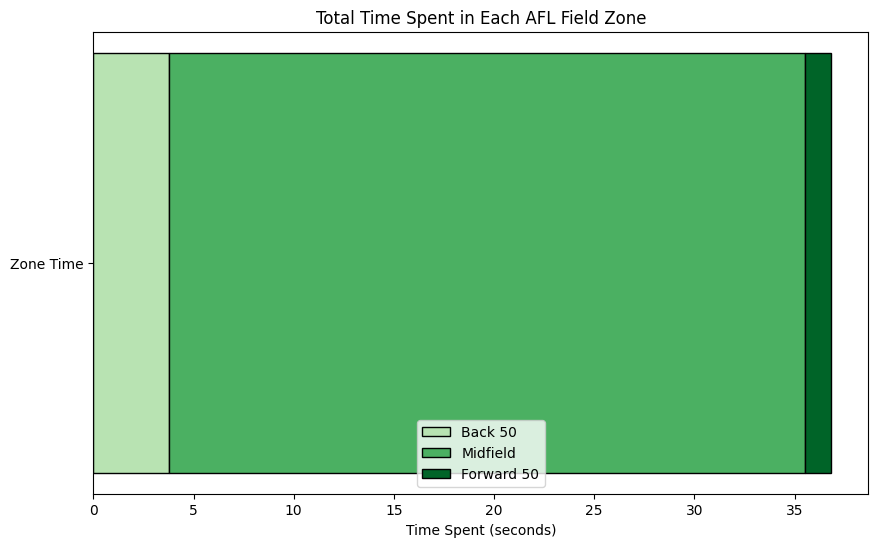

In [ ]:
import matplotlib.pyplot as plt

# Sum across all players
total_back = zone_df["back_50"].sum()
total_mid = zone_df["midfield"].sum()
total_fwd = zone_df["forward_50"].sum()

totals = [total_back, total_mid, total_fwd]
zones = ["Back 50", "Midfield", "Forward 50"]
colors = plt.cm.Greens(np.linspace(0.3, 0.9, 3))

fig, ax = plt.subplots(figsize=(10, 6))
for i, (zone, total, color) in enumerate(zip(zones, totals, colors)):
    ax.barh("Zone Time", total, left=sum(totals[:i]), color=color, edgecolor='black', label=zone)

ax.set_xlabel("Time Spent (seconds)")
ax.set_title("Total Time Spent in Each AFL Field Zone")
ax.legend()
plt.show()


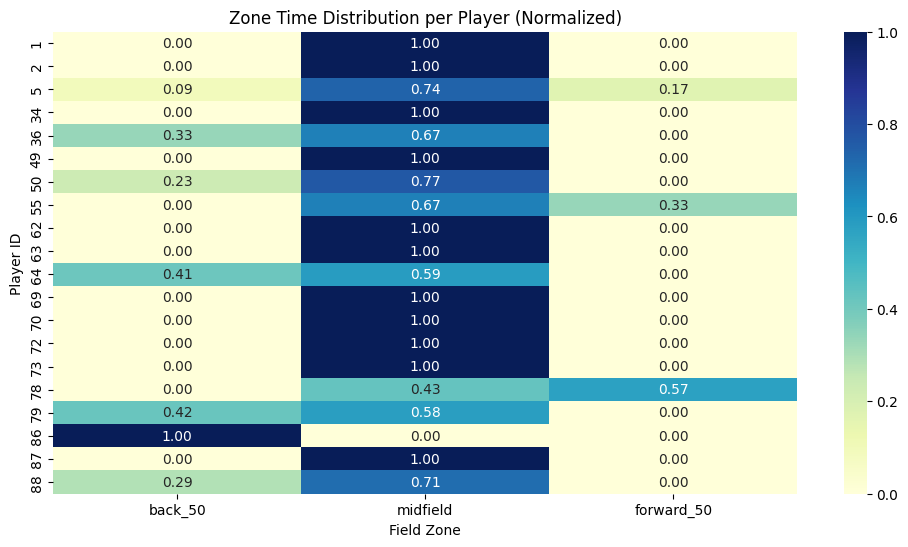

In [ ]:
import seaborn as sns

zone_df_norm = zone_df.copy()
zone_df_norm[["back_50", "midfield", "forward_50"]] = (
    zone_df[["back_50", "midfield", "forward_50"]].div(
        zone_df[["back_50", "midfield", "forward_50"]].sum(axis=1), axis=0
    )
)

plt.figure(figsize=(12, 6))
sns.heatmap(zone_df_norm.set_index("player_id"), cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Zone Time Distribution per Player (Normalized)")
plt.ylabel("Player ID")
plt.xlabel("Field Zone")
plt.show()


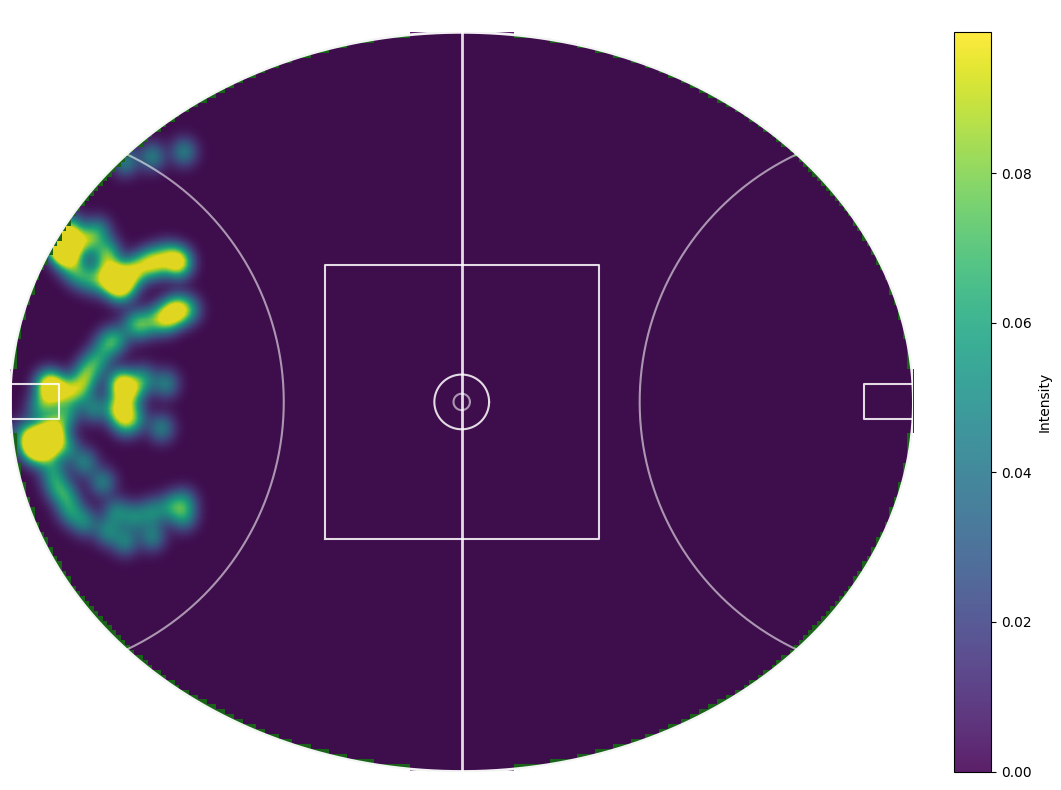

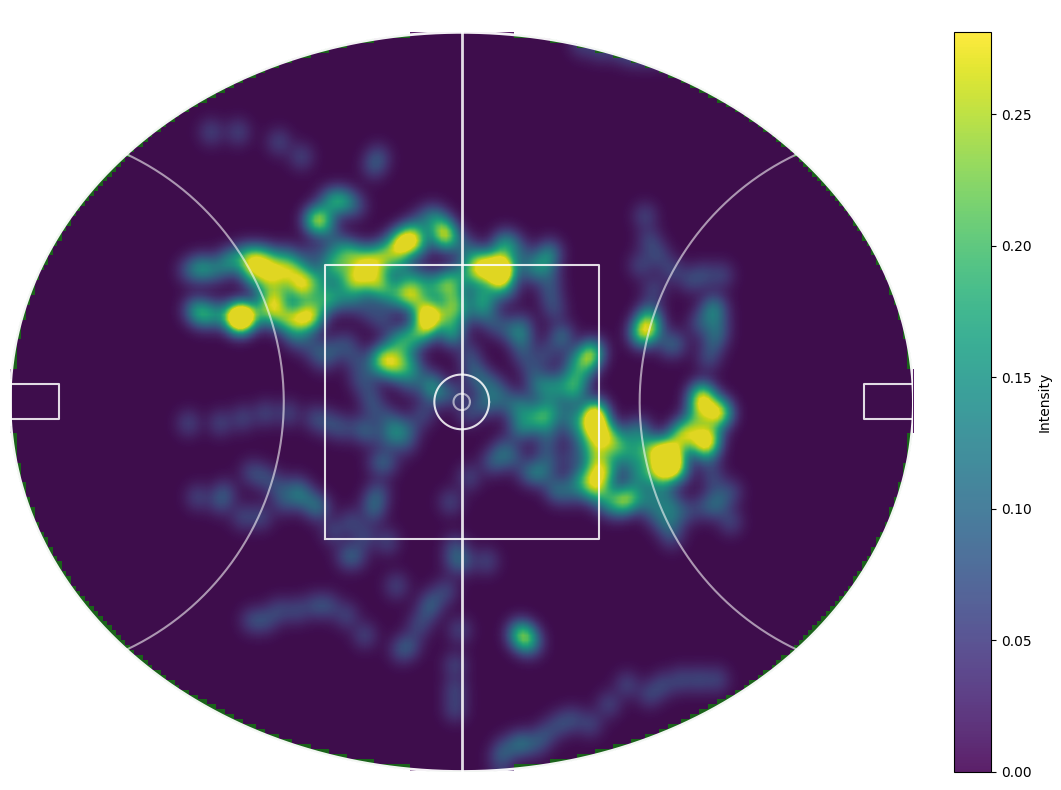

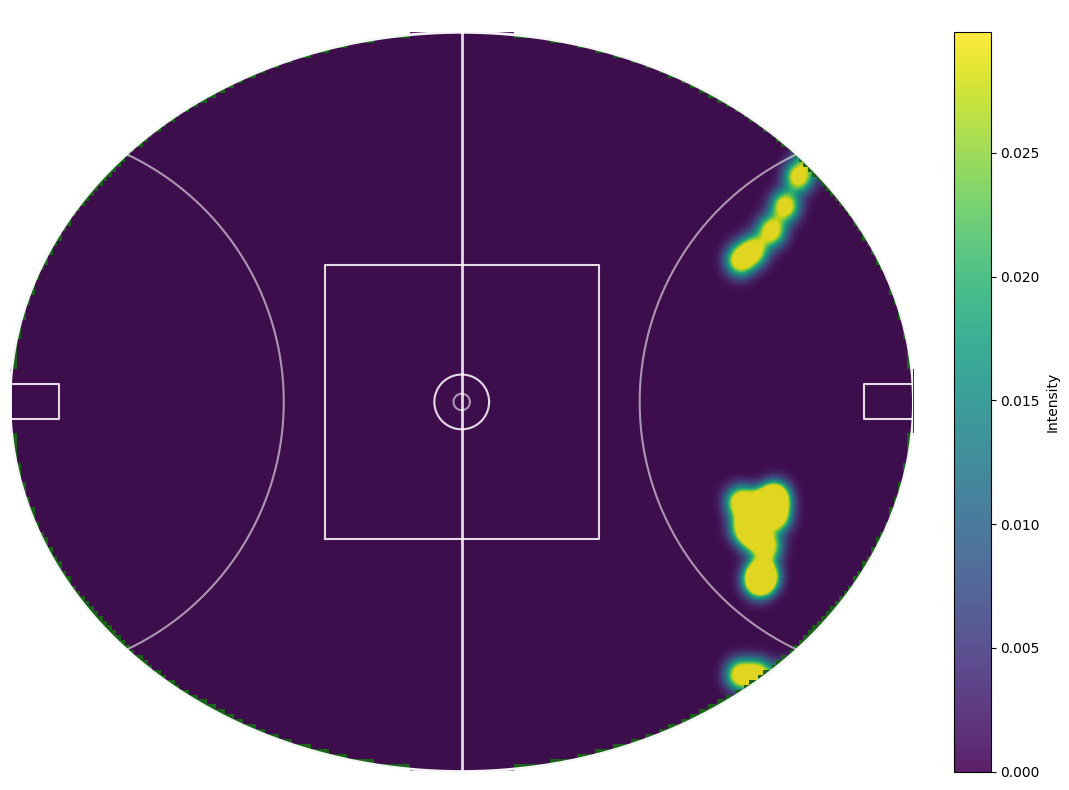

In [ ]:
# ================================
# AFL Zone Heatmaps (Colab-ready)
# ================================

# 0) (Optional in Colab) ensure deps
# !pip install numpy pandas matplotlib scipy

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.ndimage import gaussian_filter



REQUIRED_COLS = ["cx", "cy"]  # (Only need cx,cy for heatmaps here)


def raw_bbox(xs, ys, pad_ratio=0.02):
    xmin, xmax = float(np.min(xs)), float(np.max(xs))
    ymin, ymax = float(np.min(ys)), float(np.max(ys))
    dx, dy = max(xmax - xmin, 1e-9), max(ymax - ymin, 1e-9)
    return (xmin - dx*pad_ratio, xmax + dx*pad_ratio,
            ymin - dy*pad_ratio, ymax + dy*pad_ratio)

def raw_to_metres(x, y, bbox_raw, a, b):
    xmin, xmax, ymin, ymax = bbox_raw
    x_m = ((x - xmin) / max(1e-9, (xmax - xmin))) * (2*a) - a
    y_m = ((y - ymin) / max(1e-9, (ymax - ymin))) * (2*b) - b
    return x_m, y_m

def make_oval_mask_metres(nx, ny, a, b):
    x_edges = np.linspace(-a, a, nx + 1)
    y_edges = np.linspace(-b, b, ny + 1)
    xc = (x_edges[:-1] + x_edges[1:]) / 2
    yc = (y_edges[:-1] + y_edges[1:]) / 2
    Xc, Yc = np.meshgrid(xc, yc)
    mask = (Xc**2) / (a**2) + (Yc**2) / (b**2) <= 1.0
    return x_edges, y_edges, mask

def heatmap_in_metres(x_raw, y_raw, bbox_raw, a, b, nx, ny, sigma, weights=None):
    # Map to metres
    x_m, y_m = raw_to_metres(np.asarray(x_raw, float), np.asarray(y_raw, float), bbox_raw, a, b)
    # Bin grid + oval mask
    x_edges, y_edges, mask = make_oval_mask_metres(nx, ny, a, b)
    # 2D histogram in metre-space (transpose to align with imshow origin="lower")
    H, _, _ = np.histogram2d(x_m, y_m, bins=[x_edges, y_edges], weights=weights)
    H = H.T
    # Smooth
    Hs = gaussian_filter(H, sigma=sigma)
    # Mask outside oval
    Hs_masked = np.where(mask, Hs, np.nan)
    return Hs_masked, x_edges, y_edges


def draw_afl_field_metres(ax, a, b,
                          centre_square=50.0,
                          centre_inner_d=3.0,
                          centre_outer_d=10.0,
                          goal_square_depth=9.0,
                          goal_square_width=6.4,
                          arc_r=50.0,
                          line_color="white", lw=2.0, alpha=0.95,
                          show_ticks=False):
    t = np.linspace(0, 2*np.pi, 800)

    ax.plot(a*np.cos(t), b*np.sin(t), color=line_color, lw=lw, alpha=alpha)

    ax.plot([0, 0], [-b, b], color=line_color, lw=lw, alpha=alpha*0.9)

    cs = centre_square/2.0
    ax.plot([-cs,  cs,  cs, -cs, -cs], [-cs, -cs, cs, cs, -cs],
            color=line_color, lw=lw-0.5, alpha=alpha*0.9)

    th = np.linspace(0, 2*np.pi, 400)
    ax.plot((centre_outer_d/2.0)*np.cos(th), (centre_outer_d/2.0)*np.sin(th),
            color=line_color, lw=lw-0.5, alpha=alpha*0.9)
    ax.plot((centre_inner_d/2.0)*np.cos(th), (centre_inner_d/2.0)*np.sin(th),
            color=line_color, lw=lw-0.5, alpha=alpha*0.6)

    phi_L = np.linspace(-np.pi/2, np.pi/2, 400)
    phi_R = np.linspace(np.pi/2, 3*np.pi/2, 400)
    ax.plot(-a + arc_r*np.cos(phi_L), 0 + arc_r*np.sin(phi_L),
            color=line_color, lw=lw-0.5, alpha=alpha*0.6)
    ax.plot( a + arc_r*np.cos(phi_R), 0 + arc_r*np.sin(phi_R),
            color=line_color, lw=lw-0.5, alpha=alpha*0.6)

    gs_w = goal_square_width/2.0
    ax.plot([-a, -a+goal_square_depth, -a+goal_square_depth, -a, -a],
            [-gs_w, -gs_w, gs_w, gs_w, -gs_w],
            color=line_color, lw=lw-0.5, alpha=alpha*0.9)
    ax.plot([ a,  a-goal_square_depth,  a-goal_square_depth,  a,  a],
            [-gs_w, -gs_w, gs_w, gs_w, -gs_w],
            color=line_color, lw=lw-0.5, alpha=alpha*0.9)

    tick = 4.0
    for xg in (-a, a):
        ax.plot([xg, xg], [-tick, tick], color=line_color, lw=lw, alpha=alpha)

    if show_ticks:
        ax.set_xlabel("Metres (X)")
        ax.set_ylabel("Metres (Y)")
        ax.set_xticks(np.arange(-a, a+1e-6, 20))
        ax.set_yticks(np.arange(-b, b+1e-6, 20))
        ax.grid(alpha=0.15, linewidth=0.8)
    else:
        ax.set_axis_off()

    ax.set_aspect('equal')

def plot_heatmap_on_field_metres(H, x_edges, y_edges, a, b, title="", alpha_img=0.88, out_path=None):
    fig, ax = plt.subplots(figsize=(11, 8))

    t = np.linspace(0, 2*np.pi, 600)
    ax.fill(a*np.cos(t), b*np.sin(t), color=(0.05, 0.35, 0.05), alpha=0.95, zorder=0)

    extent = [x_edges.min(), x_edges.max(), y_edges.min(), y_edges.max()]
    finite_vals = H[np.isfinite(H)]
    vmax = (np.nanpercentile(finite_vals, 99) if finite_vals.size else np.nanmax(H)) or 1.0

    im = ax.imshow(
        H, origin="lower", extent=extent, aspect="equal",
        interpolation="bilinear", alpha=alpha_img,
        norm=Normalize(vmin=0.0, vmax=vmax), zorder=2
    )

    draw_afl_field_metres(ax, a, b, show_ticks=False)

    sb_y = -b + 8
    sb_x0, sb_x1 = -a + 12, -a + 32
    ax.plot([sb_x0, sb_x1], [sb_y, sb_y], color="white", lw=4, alpha=0.95)
    ax.text((sb_x0+sb_x1)/2, sb_y-4, "20 m", ha="center", va="top",
            color="white", fontsize=11)

    ax.set_title(title, color="white")
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Intensity")
    for spine in ax.spines.values(): spine.set_visible(False)
    plt.tight_layout()

    if out_path:
        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        fig.savefig(out_path, dpi=220)
    plt.show()


missing = [c for c in REQUIRED_COLS if c not in df.columns]
if missing:
    raise ValueError(f"CSV is missing columns: {missing}")

df = df.dropna(subset=["cx", "cy"])
df = df[np.isfinite(df["cx"]) & np.isfinite(df["cy"])]


FIELD_LENGTH_M = 165.0
FIELD_WIDTH_M  = 135.0
a = FIELD_LENGTH_M / 2.0
b = FIELD_WIDTH_M  / 2.0
nx, ny = 200, 150
sigma = 2.0

bbox_raw = raw_bbox(df["cx"].values, df["cy"].values)

x_m, y_m = raw_to_metres(df["cx"].values, df["cy"].values, bbox_raw, a, b)
df = df.assign(x_m=x_m, y_m=y_m)


df_back50   = df[df["x_m"] < -50]
df_midfield = df[(df["x_m"] >= -50) & (df["x_m"] <= 50)]
df_fwd50    = df[df["x_m"] > 50]


for sub, name in [
    (df_back50,   "Back 50 Heatmap"),
    (df_midfield, "Midfield Heatmap"),
    (df_fwd50,    "Forward 50 Heatmap"),
]:
    if sub.empty:
        print(f"Skipping empty zone: {name}")
        continue

    H, xe, ye = heatmap_in_metres(
        sub["cx"], sub["cy"],
        bbox_raw=bbox_raw, a=a, b=b, nx=nx, ny=ny, sigma=sigma
    )
    plot_heatmap_on_field_metres(H, xe, ye, a, b, title=name)

/tmp/ipython-input-1610501988.py:78: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis").copy()


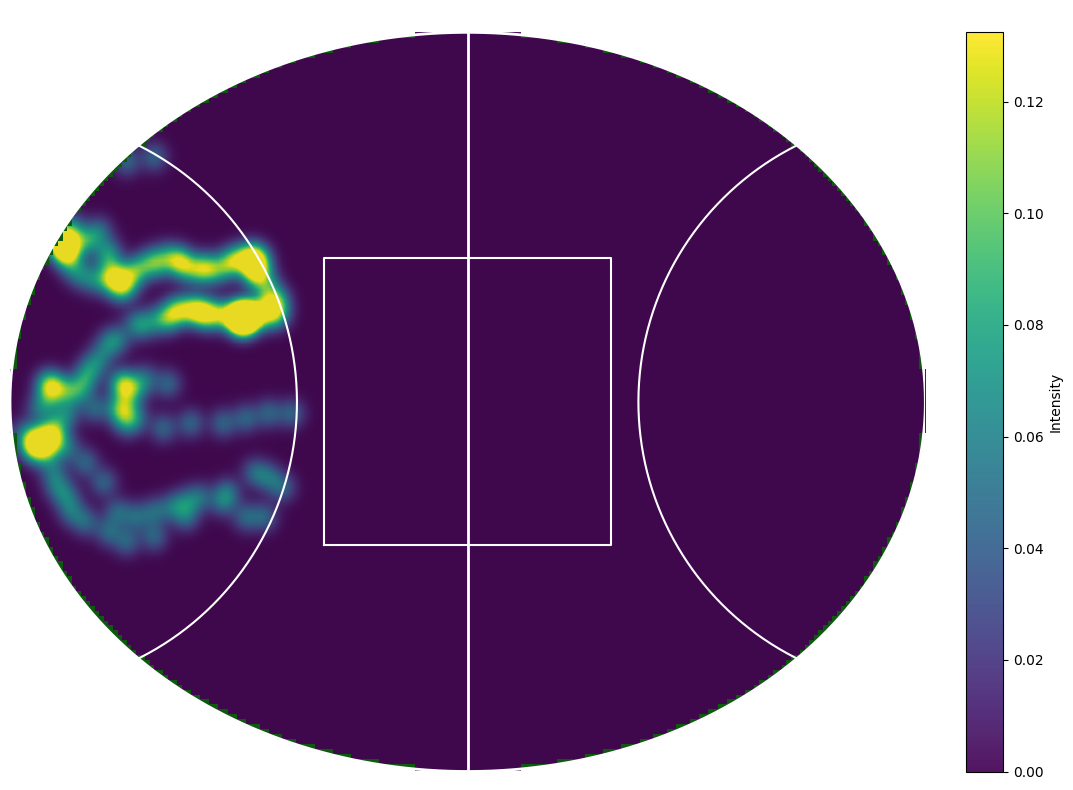

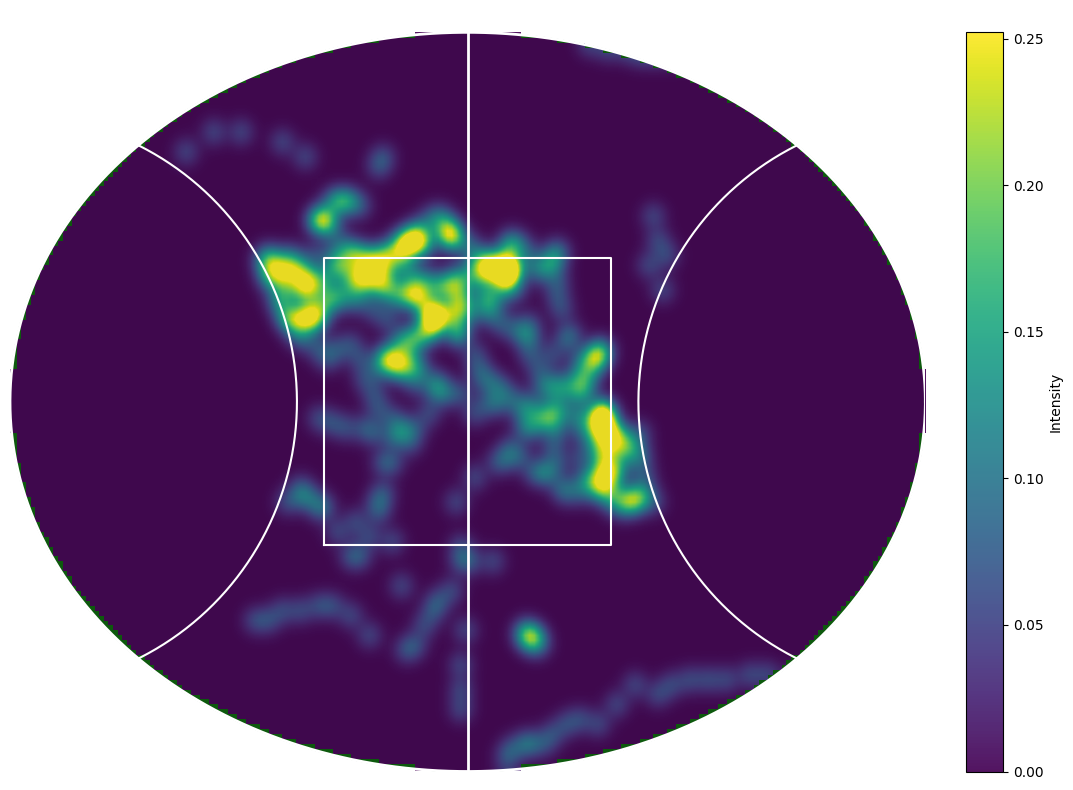

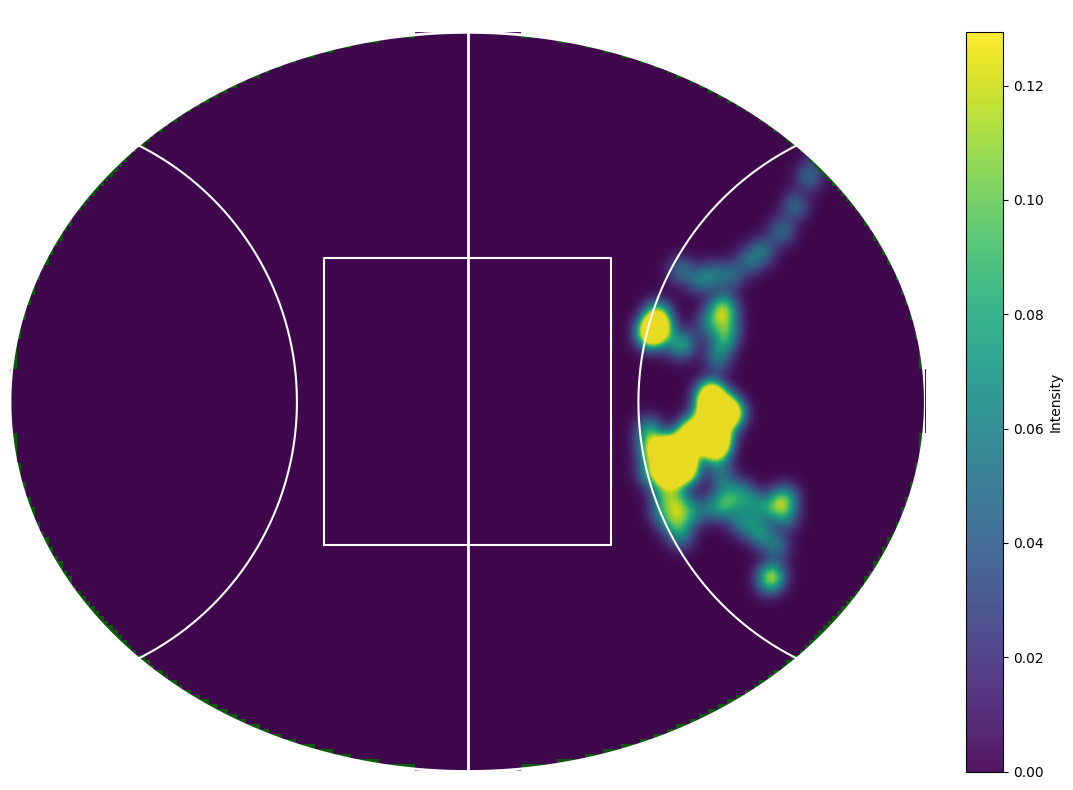

In [ ]:
# ======================================
# AFL Zone Heatmaps with Arc Zones
# ======================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from scipy.ndimage import gaussian_filter

# -------------------------
# Field setup
# -------------------------
FIELD_LENGTH_M = 159.5   # AFL ground length
FIELD_WIDTH_M  = 128.8   # AFL ground width
a = FIELD_LENGTH_M / 2.0   # semi-major axis
b = FIELD_WIDTH_M  / 2.0   # semi-minor axis

NX, NY = 200, 150
SIGMA  = 2.0

# -------------------------
# Mapping helpers
# -------------------------
def raw_bbox(xs, ys, pad_ratio=0.02):
    xmin, xmax = float(np.min(xs)), float(np.max(xs))
    ymin, ymax = float(np.min(ys)), float(np.max(ys))
    dx, dy = max(xmax - xmin, 1e-9), max(ymax - ymin, 1e-9)
    return (xmin - dx*pad_ratio, xmax + dx*pad_ratio,
            ymin - dy*pad_ratio, ymax + dy*pad_ratio)

def raw_to_metres(x, y, bbox_raw, a, b):
    xmin, xmax, ymin, ymax = bbox_raw
    x_m = ((x - xmin) / max(1e-9, (xmax - xmin))) * (2*a) - a
    y_m = ((y - ymin) / max(1e-9, (ymax - ymin))) * (2*b) - b
    return x_m, y_m

def make_oval_mask_metres(nx, ny, a, b):
    x_edges = np.linspace(-a, a, nx + 1)
    y_edges = np.linspace(-b, b, ny + 1)
    xc = (x_edges[:-1] + x_edges[1:]) / 2
    yc = (y_edges[:-1] + y_edges[1:]) / 2
    Xc, Yc = np.meshgrid(xc, yc)
    mask = (Xc**2) / (a**2) + (Yc**2) / (b**2) <= 1.0
    return x_edges, y_edges, mask

def heatmap_from_metres(x_m, y_m, a, b, nx=NX, ny=NY, sigma=SIGMA, weights=None):
    x_edges, y_edges, mask = make_oval_mask_metres(nx, ny, a, b)
    H, _, _ = np.histogram2d(x_m, y_m, bins=[x_edges, y_edges], weights=weights)
    H = H.T
    if sigma and sigma > 0:
        H = gaussian_filter(H, sigma=sigma)
    H_masked = np.where(mask, H, np.nan)
    return H_masked, x_edges, y_edges

# -------------------------
# AFL field drawing
# -------------------------
def draw_afl_field(ax, a, b, line_color="white", lw=2.0):
    t = np.linspace(0, 2*np.pi, 800)
    ax.plot(a*np.cos(t), b*np.sin(t), color=line_color, lw=lw)   # oval boundary
    ax.plot([0, 0], [-b, b], color=line_color, lw=lw)            # centre line
    cs = 25
    ax.plot([-cs, cs, cs, -cs, -cs], [-cs, -cs, cs, cs, -cs], color=line_color, lw=lw-0.5)
    phi = np.linspace(-np.pi/2, np.pi/2, 400)
    ax.plot(-a + 50*np.cos(phi), 50*np.sin(phi), color=line_color, lw=lw-0.5)
    ax.plot( a - 50*np.cos(phi), 50*np.sin(phi), color=line_color, lw=lw-0.5)

# -------------------------
# Plot helper
# -------------------------
def plot_heatmap(H, x_edges, y_edges, a, b, title):
    fig, ax = plt.subplots(figsize=(11,8))
    t = np.linspace(0,2*np.pi,600)
    ax.fill(a*np.cos(t), b*np.sin(t), color=(0.05,0.35,0.05), zorder=0)

    cmap = cm.get_cmap("viridis").copy()
    cmap.set_bad((0,0,0,0))

    extent=[x_edges.min(),x_edges.max(),y_edges.min(),y_edges.max()]
    finite_vals = H[np.isfinite(H)]
    vmax = (np.nanpercentile(finite_vals,99) if finite_vals.size else 1.0)

    im = ax.imshow(H, origin="lower", extent=extent, aspect="equal",
                   cmap=cmap, norm=Normalize(vmin=0,vmax=vmax),
                   interpolation="bilinear", alpha=0.92, zorder=1)

    draw_afl_field(ax, a, b)
    ax.set_xlim([-a, a]); ax.set_ylim([-b, b])
    ax.set_aspect("equal"); ax.set_axis_off()
    ax.set_title(title, color="white")

    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Intensity")
    plt.tight_layout()
    plt.show()

# -------------------------
# Circular Zone Splitter
# -------------------------
def split_zones(df):
    # Distances from each goalpost centre (-a,0) and (+a,0)
    dist_left  = np.sqrt((df["x_m"] + a)**2 + df["y_m"]**2)
    dist_right = np.sqrt((df["x_m"] - a)**2 + df["y_m"]**2)

    back50   = df[dist_left <= 50].copy()
    forward50= df[dist_right <= 50].copy()
    midfield = df[(dist_left > 50) & (dist_right > 50)].copy()

    return {"Back 50": back50, "Midfield": midfield, "Forward 50": forward50}

# -------------------------
# Runner
# -------------------------
def run_zones(csv_path):
    df = pd.read_csv(csv_path)
    if not {"cx","cy"}.issubset(df.columns):
        raise ValueError("CSV must have cx, cy columns")

    df = df.dropna(subset=["cx","cy"]).copy()
    bbox_raw = raw_bbox(df["cx"], df["cy"])
    df["x_m"], df["y_m"] = raw_to_metres(df["cx"], df["cy"], bbox_raw, a, b)

    zones = split_zones(df)
    for name, sub in zones.items():
        if sub.empty:
            print(f"⚠️ No data in zone: {name}")
            continue
        H, xe, ye = heatmap_from_metres(sub["x_m"], sub["y_m"], a, b, NX, NY, SIGMA)
        plot_heatmap(H, xe, ye, a, b, f"{name} Heatmap")

# -------------------------
# Run
# -------------------------
run_zones("tracking_csv.csv")


/tmp/ipython-input-72158969.py:121: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis").copy()


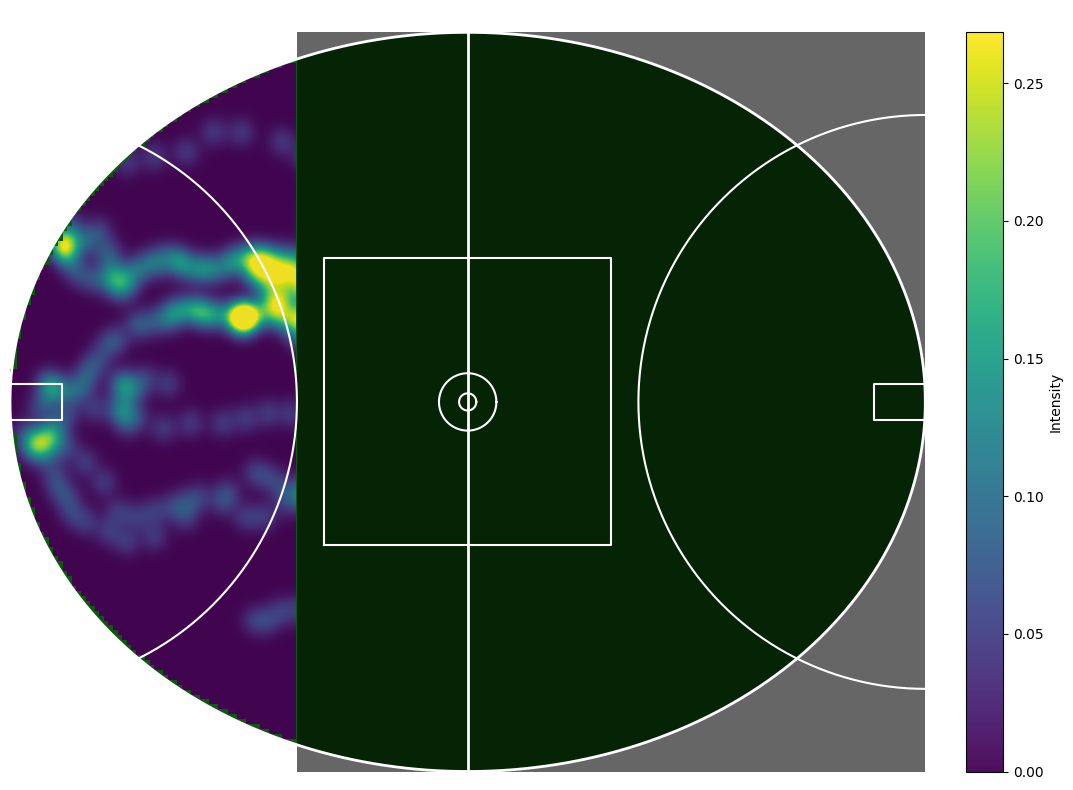

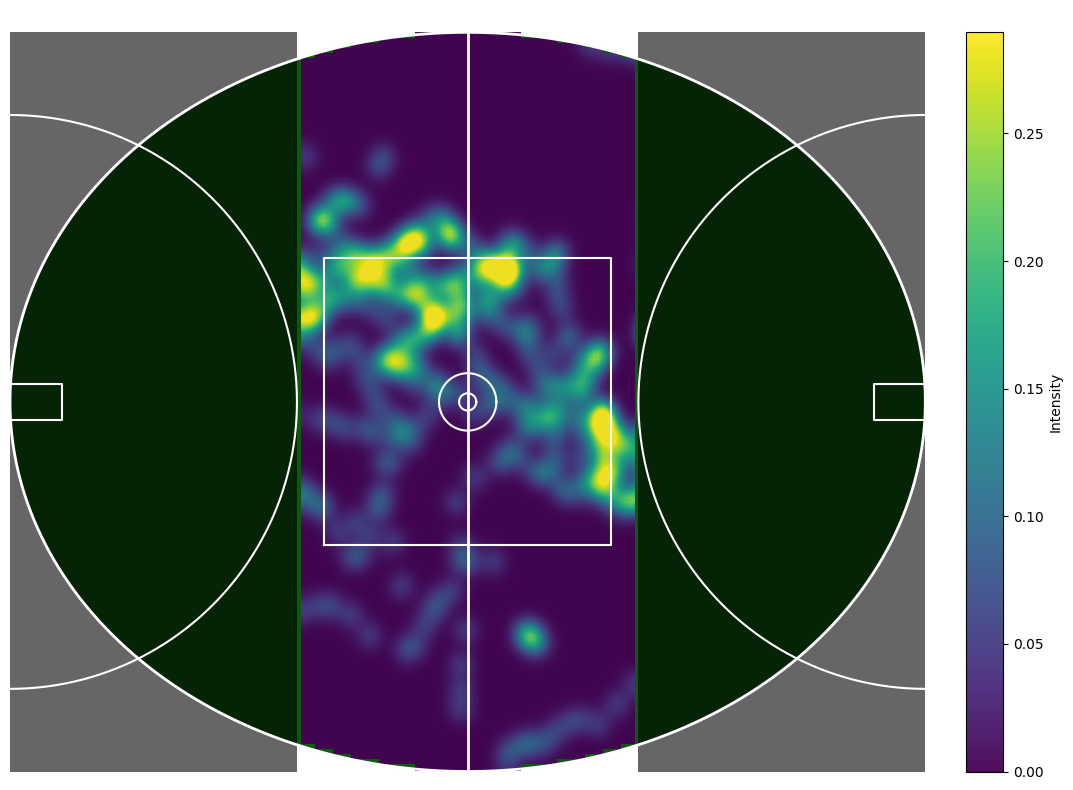

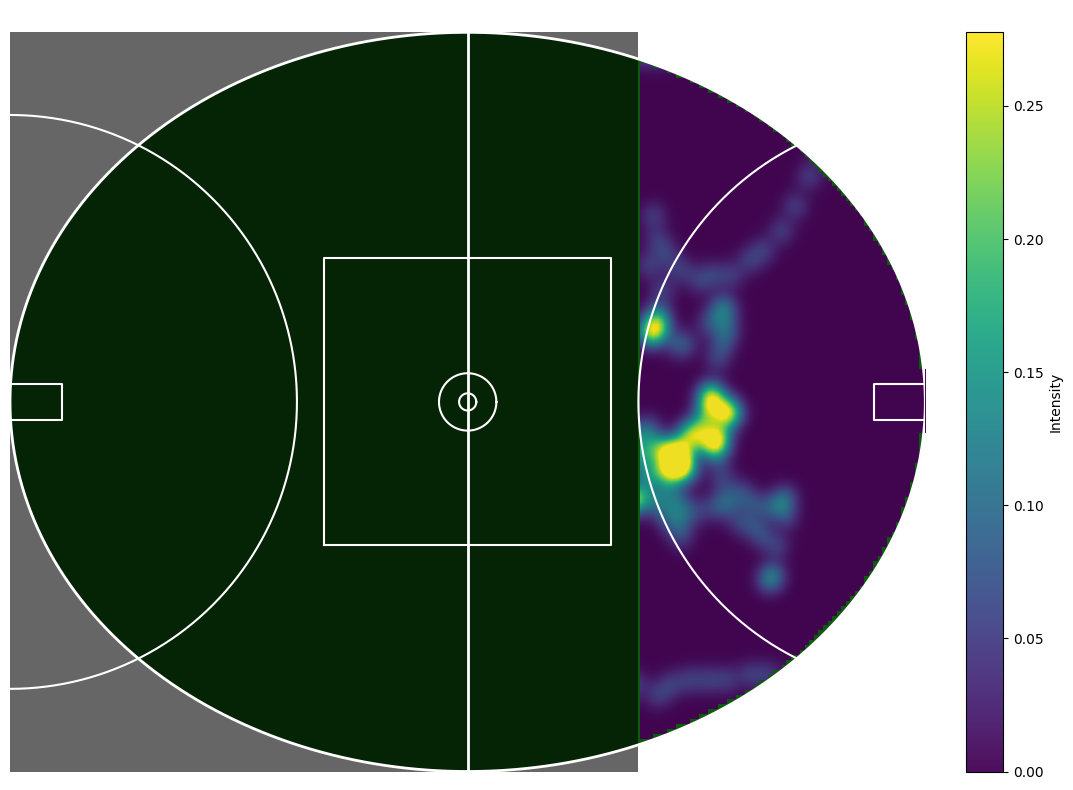

In [ ]:
# =========================================================
# AFL zone views: show full heatmap, hide other zones via overlays
# =========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.patches import Rectangle
from scipy.ndimage import gaussian_filter

# ---------- Field ----------
FIELD_LENGTH_M = 159.5
FIELD_WIDTH_M  = 128.8
a = FIELD_LENGTH_M / 2.0   # semi-major (x)
b = FIELD_WIDTH_M  / 2.0   # semi-minor (y)

LEFT_50_X  = -a + 50.0
RIGHT_50_X =  a - 50.0

NX, NY = 200, 150
SIGMA  = 2.0

# ---------- helpers ----------
def raw_bbox(xs, ys, pad_ratio=0.02):
    xmin, xmax = float(np.min(xs)), float(np.max(xs))
    ymin, ymax = float(np.min(ys)), float(np.max(ys))
    dx, dy = max(xmax - xmin, 1e-9), max(ymax - ymin, 1e-9)
    return (xmin - dx*pad_ratio, xmax + dx*pad_ratio,
            ymin - dy*pad_ratio, ymax + dy*pad_ratio)

def raw_to_metres(x, y, bbox_raw, a, b):
    xmin, xmax, ymin, ymax = bbox_raw
    x_m = ((x - xmin) / max(1e-9, (xmax - xmin))) * (2*a) - a
    y_m = ((y - ymin) / max(1e-9, (ymax - ymin))) * (2*b) - b
    return x_m, y_m

def make_grid_and_mask(nx, ny, a, b):
    x_edges = np.linspace(-a, a, nx + 1)
    y_edges = np.linspace(-b, b, ny + 1)
    xc = 0.5*(x_edges[:-1] + x_edges[1:])
    yc = 0.5*(y_edges[:-1] + y_edges[1:])
    Xc, Yc = np.meshgrid(xc, yc, indexing="xy")
    oval_mask = (Xc**2)/(a**2) + (Yc**2)/(b**2) <= 1.0
    return x_edges, y_edges, Xc, Yc, oval_mask

def heatmap_from_metres(xm, ym, a, b, nx=NX, ny=NY, sigma=SIGMA):
    x_edges, y_edges, Xc, Yc, oval_mask = make_grid_and_mask(nx, ny, a, b)
    H, _, _ = np.histogram2d(xm, ym, bins=[x_edges, y_edges])
    H = H.T
    if sigma and sigma > 0:
        H = gaussian_filter(H, sigma=sigma)
    H = np.where(oval_mask, H, np.nan)
    return H, x_edges, y_edges, Xc, Yc

def draw_afl_field(ax, a, b,
                   centre_square=50.0,
                   centre_inner_d=3.0,
                   centre_outer_d=10.0,
                   goal_square_depth=9.0,
                   goal_square_width=6.4,
                   arc_r=50.0,
                   line_color="white", lw=2.0, z=4):
    t = np.linspace(0, 2*np.pi, 800)
    ax.plot(a*np.cos(t), b*np.sin(t), color=line_color, lw=lw, zorder=z)
    ax.plot([0, 0], [-b, b], color=line_color, lw=lw, zorder=z)

    cs = centre_square/2.0
    ax.plot([-cs, cs, cs, -cs, -cs], [-cs, -cs, cs, cs, -cs],
            color=line_color, lw=lw-0.5, zorder=z)

    th = np.linspace(0, 2*np.pi, 400)
    ax.plot((centre_outer_d/2.0)*np.cos(th), (centre_outer_d/2.0)*np.sin(th),
            color=line_color, lw=lw-0.5, zorder=z)
    ax.plot((centre_inner_d/2.0)*np.cos(th), (centre_inner_d/2.0)*np.sin(th),
            color=line_color, lw=lw-0.5, zorder=z)

    phi = np.linspace(-np.pi/2, np.pi/2, 400)
    ax.plot(-a + arc_r*np.cos(phi), arc_r*np.sin(phi), color=line_color, lw=lw-0.5, zorder=z)
    ax.plot( a - arc_r*np.cos(phi), arc_r*np.sin(phi), color=line_color, lw=lw-0.5, zorder=z)

    gs_w = goal_square_width/2.0
    ax.plot([-a, -a+goal_square_depth, -a+goal_square_depth, -a, -a],
            [-gs_w, -gs_w, gs_w, gs_w, -gs_w],
            color=line_color, lw=lw-0.5, zorder=z)
    ax.plot([ a,  a-goal_square_depth,  a-goal_square_depth,  a,  a],
            [-gs_w, -gs_w, gs_w, gs_w, -gs_w],
            color=line_color, lw=lw-0.5, zorder=z)

def base_axes(a, b):
    fig, ax = plt.subplots(figsize=(11,8))
    t = np.linspace(0, 2*np.pi, 600)
    ax.fill(a*np.cos(t), b*np.sin(t), color=(0.05,0.35,0.05), zorder=0)  # grass
    ax.set_xlim([-a, a]); ax.set_ylim([-b, b])
    ax.set_aspect('equal'); ax.set_axis_off()
    return fig, ax

def show_zone_view(H, x_edges, y_edges, a, b, zone_name,
                   Xc, shade_other_zones=True, shade_alpha=0.55):
    """Render the same global heatmap but only show the chosen zone.
       Others are dimmed with semi-transparent overlays (or hard-masked if shade_other_zones=False)."""
    fig, ax = base_axes(a, b)

    # zone masks on grid-centres
    back_mask   = (Xc <= LEFT_50_X)
    mid_mask    = (Xc >  LEFT_50_X) & (Xc < RIGHT_50_X)
    fwd_mask    = (Xc >= RIGHT_50_X)

    zones = {
        "Back 50": back_mask,
        "Midfield": mid_mask,
        "Forward 50": fwd_mask
    }
    chosen = zones[zone_name]

    # mask heatmap outside chosen zone (so green shows through)
    H_zone = np.where(chosen, H, np.nan)

    # draw heatmap
    cmap = cm.get_cmap("viridis").copy()
    cmap.set_bad((0,0,0,0))
    finite = H_zone[np.isfinite(H_zone)]
    vmax = np.nanpercentile(finite, 99) if finite.size else 1.0
    extent = [x_edges.min(), x_edges.max(), y_edges.min(), y_edges.max()]
    im = ax.imshow(H_zone, origin='lower', extent=extent, aspect='equal',
                   cmap=cmap, norm=Normalize(vmin=0, vmax=vmax),
                   interpolation='bilinear', alpha=0.95, zorder=1)

    # optional: dim other zones with translucent rectangles (on top of heatmap)
    if shade_other_zones:
        # (left) back 50
        if zone_name != "Back 50":
            ax.add_patch(Rectangle((-a, -b), (LEFT_50_X - (-a)), 2*b,
                                   facecolor='black', alpha=shade_alpha, zorder=2, linewidth=0))
        # (middle) midfield
        if zone_name != "Midfield":
            ax.add_patch(Rectangle((LEFT_50_X, -b), (RIGHT_50_X - LEFT_50_X), 2*b,
                                   facecolor='black', alpha=shade_alpha, zorder=2, linewidth=0))
        # (right) fwd 50
        if zone_name != "Forward 50":
            ax.add_patch(Rectangle((RIGHT_50_X, -b), (a - RIGHT_50_X), 2*b,
                                   facecolor='black', alpha=shade_alpha, zorder=2, linewidth=0))

    draw_afl_field(ax, a, b, z=4)
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Intensity")
    ax.set_title(f"{zone_name} (overlay)", color="white")
    plt.tight_layout()
    plt.show()

# ---------- Load + build global heatmap once ----------
df = pd.read_csv("tracking_csv.csv").dropna(subset=["cx","cy"]).copy()
bbox = raw_bbox(df["cx"].values, df["cy"].values)
x_m, y_m = raw_to_metres(df["cx"].values, df["cy"].values, bbox, a, b)

# global heatmap (all data)
H, xe, ye, Xc, Yc = heatmap_from_metres(x_m, y_m, a, b, NX, NY, SIGMA)

# ---------- Show three views with overlays ----------
for zname in ["Back 50", "Midfield", "Forward 50"]:
    show_zone_view(H, xe, ye, a, b, zname, Xc,
                   shade_other_zones=True,  # set False to hard-mask (no dim overlays)
                   shade_alpha=0.6)
